# 3: Power Outage Identification: Preprocessing and Word2Vec Model

### Contents:
- [Imports](#Imports)
- [Preprocessing](#Preprocessing)
- [Word2Vec Model](#Word2Vec-Model)
  * [Train Model](#Train-Model)
- [t-SNE Model Exploration](#t-SNE-Model-Exploration)  
  * [Visualization](#Visualization)
  * [Exporting Visual](#Exporting-Visual)
- [Evaluation](#Evaluation)  

## Imports

In [1]:
# Importing packages
from __future__ import absolute_import, division, print_function
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import codecs
import glob
import multiprocessing
import os
import pprint
import re
import nltk
from nltk.corpus import stopwords

#importing warning to turn off future warnings
import warnings
warnings.simplefilter(action='ignore')

/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


## Preprocessing

Based on what we learned when reviewing our data in EDA, we set out to prepare the text for modelling lower casing the text and removing punctuation and stopwords. We also removed complete url strings before tokenizing to make sure we captured all the url pieces, especially link shorteners. We printed out a sample tweet as it was altered to confirm that each step processed correctly.

In [2]:
#reading in the data
all_tweets_df = pd.read_csv('./datasets/combined_data.csv')
all_tweets_df.drop(columns='Unnamed: 0', inplace = True)
print(f'Shape of DataFrame: {all_tweets_df.shape}')
all_tweets_df.head()

Shape of DataFrame: (5684, 9)


id                                               text  \
0  9.732586e+17  Power outage in the area causing delays. treat...   
1  1.036794e+18  Aaaaaand the power is out. (@ La Casa De Los K...   
2  1.035702e+18  Lack of #fridaynightlights here...  #powerouta...   
3  1.021838e+18  Multiple signals on flash due to a power outag...   
4  6.906223e+17  ATXoutage update: outage was caused by a hit p...   

             timestamp             user location   datestamp  \
0  2018-03-12 18:04:57  TotalTrafficAUS   Austin  2018-03-12   
1   2018-09-04 1:52:41         Daragaya   Austin  2018-09-04   
2   2018-09-01 1:33:58      MartinGarza   Austin  2018-09-01   
3  2018-07-24 19:23:17  TotalTrafficAUS   Austin  2018-07-24   
4  2016-01-22 19:49:32        Austin_CP   Austin  2016-01-22   

           date_place                combined_text  \
0  2018-03-12, Austin            dry, hot, cold ||   
1  2018-09-04, Austin        downpour, hot, hot ||   
2  2018-09-01, Austin       dry, scorching, hot ||   
3  2018-07-24, Austin  downpour, scorching, hot ||   
4  2016-01-22, Austin      downpour, warm, cold ||   

                                            all_text  
0  Power outage in the area causing delays. treat...  
1  Aaaaaand the power is out. (@ La Casa De Los K...  
2  Lack of #fridaynightlights here...  #powerouta...  
3  Multiple signals on flash due to a power outag...  
4  ATXoutage update: outage was caused by a hit p...

In [3]:
# create series just containing the text column
all_tweets = all_tweets_df['all_text']
print(f'Number of tweets: {len(all_tweets)}')

Number of tweets: 5684


In [4]:
# setting stopwords
stop_words = stopwords.words('english')

In [5]:
# Function to clean up tweets (removing urls, non-alphabetical characters)
def tweets_to_tweetlist(raw):
    clean = re.sub(r"[^a-zA-Z ]", "", raw)
    clean = re.sub(r"http.*?\b","",clean)
    clean = re.sub(r"pictwitter.*?\b","",clean)
    clean = re.sub(r"www.*?\b","",clean)
    clean = re.sub(r'instagramcom.*?\b','',clean)
    return clean

In [6]:
# Iterate through all_tweets, clean tweets and add to tweet_list
tweet_list = []
for tweet in all_tweets:
    tweet_list.append(tweets_to_tweetlist(tweet))
len(tweet_list)

5684

In [7]:
# Iterate through tweet_list convert to lowercase and tokenize each tweet
tokenized_tweet_list = [tweet.lower().split(' ') for tweet in tweet_list]   

In [8]:
# Remove stop words from tweets
# final_tweet_list is the version of our tweet list we will use from here on
final_tweet_list = []
for tweet in tokenized_tweet_list:
    word_list = []
    for word in tweet:
        if (word not in stop_words) & (word != ''):
            word_list.append(word)
    final_tweet_list.append(word_list)

In [9]:
#Seeing how many tweets we'll be working with
len(final_tweet_list)

5684

In [10]:
# Count number of words in tweets list (all tweets)
token_count = sum([len(tweet) for tweet in final_tweet_list])
print(f"The tweet list contains {token_count} tokens")

The tweet list contains 68989 tokens


In [11]:
# Compare different versions of tweets and see how they changed
def compare_tweets(n):    
    print(all_tweets[n]) # original version of nth tweet
    print()
    print(tweet_list[n]) # cleaned version of nth tweet
    print()
    print(tokenized_tweet_list[n]) # tokenized version of nth tweet
    print()
    print(final_tweet_list[n]) # tokenized version of nth tweet (stopwords removed)

In [12]:
#calling the first tweet 
compare_tweets(0)

Power outage in the area causing delays. treat as all way stop. in #Austin on Parmer Ln at Dessau Rd #ATXtraffic http://bit.ly/10BGKax , dry, hot, cold ||

Power outage in the area causing delays treat as all way stop in Austin on Parmer Ln at Dessau Rd ATXtraffic  dry hot cold 

['power', 'outage', 'in', 'the', 'area', 'causing', 'delays', 'treat', 'as', 'all', 'way', 'stop', 'in', 'austin', 'on', 'parmer', 'ln', 'at', 'dessau', 'rd', 'atxtraffic', '', 'dry', 'hot', 'cold', '']

['power', 'outage', 'area', 'causing', 'delays', 'treat', 'way', 'stop', 'austin', 'parmer', 'ln', 'dessau', 'rd', 'atxtraffic', 'dry', 'hot', 'cold']


## Word2Vec Model

We chose to use Word2Vec to model our data because of the way it focuses on the relationship of words and gives weight to that value. It maps the words from our dataset into a high dimensional space using a neural network. From that, we are able to train the model so that it can “learn” the conceptual relationship between words.  We wanted to use Word2Vec because it brings context of word choices into play, which will give us a better understanding of the group of words used in a tweet to talk about a power outage.  

In [13]:
# Instantiate Word2Vec model
tweets2vec = w2v.Word2Vec(
    sg = 1, # skip-gram train algo
    seed = 42, # Random Number Generator to make results repeatable
    workers = multiprocessing.cpu_count(), # number of threads
    size = 300, # Dimensionality of the hidden layer
    min_count = 3, # how many times the word has to appear to be kept in the vocab.
    window = 7, # size of the window to train words
    sample = 1e-5 # downsampling setting for frequent words
)

In [14]:
# Build tweets2vec vocabulary, haven't trained it yet, just loading it into memory
tweets2vec.build_vocab(final_tweet_list)

In [15]:
# how long is our tweets2vec vocabulary?
print("Tweets2Vec vocabulary length:", len(tweets2vec.wv.vocab))

Tweets2Vec vocabulary length: 2471


### Train Model

We trained our model on our tweet list so that it could "learn" the relationship of the words in the dataset.

In [16]:
# Train tweets2vec model on final_tweet_list
tweets2vec.train(final_tweet_list, total_examples=tweets2vec.corpus_count, epochs=tweets2vec.epochs)

(40139, 344945)

In [17]:
# Create directory to store our trained tweets2vec model in
if not os.path.exists("./datasets/training_model"):
    os.makedirs("./datasets/training_model")

In [18]:
# Save our trained tweets2vec model in the trained folder
tweets2vec.wv.save("./datasets/training_model/tweets2vec.w2v")

## t-SNE Model Exploration

While machines have no problem understanding high dimensional space, we needed to convert it back to two-dimensional space in order to examine and understand it. We used a t-SNE model for dimensionality reduction.

In [19]:
# reading in the trained data to explore it
tweets2vec = tweets2vec.wv.load("./datasets/training_model/tweets2vec.w2v")

In [20]:
# this is a word vector in 300 dimensional word space. We need to take it down a bit using TSNE
# That is t-distributed Stochastic Neighbor Embedding. Essentially it is a tool to visualize high-dimensional data.
# Takes a 300 dim vector and squashes it into 2 and derives coordinates from them.
tsne = sklearn.manifold.TSNE(n_components = 2, random_state = 42, perplexity= 70,learning_rate = 150,verbose =1,n_iter=5000)

In [21]:
all_word_vectors_matrix = tweets2vec.wv.syn0

In [22]:
# Training it will take some time...
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 2471 samples in 0.018s...
[t-SNE] Computed neighbors for 2471 samples in 3.124s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2471
[t-SNE] Computed conditional probabilities for sample 2000 / 2471
[t-SNE] Computed conditional probabilities for sample 2471 / 2471
[t-SNE] Mean sigma: 0.003650
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.039215
[t-SNE] KL divergence after 1600 iterations: 3.013568


In [23]:
#creating a dataframe of the t-SNE coordinates
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[tweets2vec.vocab[word].index])
            for word in tweets2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [24]:
# Edited code from Boom Devahastin Na Ayudhya
# Define vectorization function
def vectorize_corpus(keyword_list):    
    
    # Instantiate counter for number of words in keyword_list that exists
    n_words = 0
    
    # Create template for cumulative corpus vector sum
    corpus_vec_sum = np.zeros((1,300))                 
    
    # Scan through each word in list
    for word in keyword_list:
        if word in tweets2vec.vocab:                    
            word_vec = tweets2vec.word_vec(word)        
            n_words +=1                                
            corpus_vec_sum = corpus_vec_sum + word_vec 

    # Compute average vector by taking cumulative vector sum and dividing it by number of words traced
    corpus_avg_vec = corpus_vec_sum/n_words
    
    # Squeeze this N-dimensional nested array object into a 1-D array to streamline future processing
    corpus_avg_vec = np.squeeze(corpus_avg_vec)
    
    return(corpus_avg_vec)

In [25]:
#defining cosine similarity function
def cos_sim(vector_1, vector_2):
    dp = np.dot(vector_1, vector_2)
    magnitude_v1 = np.sqrt(np.dot(vector_1,vector_1))
    magnitude_v2 = np.sqrt(np.dot(vector_2,vector_2))
    return(dp/(magnitude_v1*magnitude_v2))

To classify our tweets, we set up a list of positive and negative words for them to be compared to, using a cosine similarity score. The keyword lists were developed by exploring the dataset and extracting words that related more to power outages versus words that related to outages that were not power related. These included telecommunications outages as well as websites doing down such as Netflix or Facebook.

We edited this list as we fine tuned our model, watching for any misclassification word patterns.

In [26]:
#creating our pos/neg keyword lists 

# List of words for legitimate outages
power_out = ['generators','flooding','austinenergy','santaclarapower','grid', 'massive',
           'failure','generator','darkness','utoutage','powers','txuenergy','thunderstorms',
           'major', 'serious', 'surge', 'storm','storms','transformer','power','windstorm',
           'substation', 'alert', 'electrical', 'lights','thunderstorm','snake',
           'lightning','electricity','poweroutage','delays','atxoutage','nopower','lightsout',
           'candlelight','candle','candles','comed','coned','conedison','cnpalerts']

# List of words for non-legitimate outages (such as internet, Netflix, Facebook, or other service outages)
not_out = ['lines','whatsapp','aws','airworldwide','broadband','askspectrum','amtrack','dropbox',
               'twitter','skype','instagram','insta','espnfantasy','directv','netflix',
               'hulu', 'warner','microsoft','cable','tw','service','time',
               'twc','itunes','apple','attcares','attcustomercare','att','phones',
               'youtube','yt','facebook','centurylink','connectivity','network',
               'gmail','uverse', 'verizon', 'tmobile', 'phone', 'sprintcare',
               'sprint','wifi','internet', 'wireless', 'comcast','rcn','grandecom',
               'comcastcares','rcnconnects','playstation','sony','xfinity',
               'ig','fb','twchelp','nationwide','google','googlefiber','frontier','frontiercorp']

In [27]:
#vectorizing the keyword lists
power_out_vec = vectorize_corpus(power_out)
not_out_vec = vectorize_corpus(not_out)

In [28]:
#scoring words against our keywords
points['power_out_cs'] = [cos_sim(tweets2vec.word_vec(word),power_out_vec) for word in points['word']]
points['not_out_cs'] = [cos_sim(tweets2vec.word_vec(word),not_out_vec) for word in points['word']]
points['power_out_label'] = np.where(points['power_out_cs'] >= points['not_out_cs'],'power_out','not_out')
points.head()

word         x         y  power_out_cs  not_out_cs power_out_label
0    power -3.671235 -2.762214      0.857823    0.851104       power_out
1   outage -3.670921 -2.762334      0.845173    0.846326         not_out
2     area -3.419214 -2.606743      0.710348    0.684348       power_out
3  causing -2.758319 -1.879471      0.454203    0.450156       power_out
4   delays -1.787125  2.302602      0.318313    0.208895       power_out

In [29]:
#getting the counts for each label
points['power_out_label'].value_counts()

not_out      1249
power_out    1222
Name: power_out_label, dtype: int64

In [30]:
#sorting to see what words appear up top for legitimate power outages
points[points['power_out_label'] == 'power_out'].sort_values(by = 'power_out_cs',ascending = False).head(10)

word         x         y  power_out_cs  not_out_cs power_out_label
0         power -3.671235 -2.762214      0.857823    0.851104       power_out
14         cold -3.612899 -2.721791      0.774442    0.758663       power_out
61   torrential -3.543688 -2.668253      0.734049    0.699424       power_out
25    scorching -3.464567 -2.619256      0.712477    0.694633       power_out
2          area -3.419214 -2.606743      0.710348    0.684348       power_out
19     downpour -3.458040 -2.603363      0.710071    0.648915       power_out
188        near -3.347041 -2.543328      0.630426    0.593552       power_out
85        going -3.057722 -2.348081      0.595886    0.535547       power_out
139        like -3.122435 -2.525990      0.589378    0.547061       power_out
86        still -3.120433 -2.366208      0.579332    0.574292       power_out

In [31]:
#seeing what the top are for not a legitamate power outage
points[points['power_out_label'] == 'not_out'].sort_values(by = 'not_out_cs',ascending = False).head(10)

word         x         y  power_out_cs  not_out_cs power_out_label
40       warm -3.671780 -2.761733      0.845584    0.847506         not_out
1      outage -3.670921 -2.762334      0.845173    0.846326         not_out
12        dry -3.663504 -2.755629      0.842347    0.843771         not_out
13        hot -3.658734 -2.752410      0.816211    0.823254         not_out
237  freezing -3.599849 -2.714689      0.769471    0.773271         not_out
53    without -3.588773 -2.705294      0.732225    0.756808         not_out
87    morning -3.267013 -2.510391      0.614370    0.677016         not_out
82   internet -3.323227 -2.539843      0.571090    0.652109         not_out
134       one -3.248070 -2.511913      0.609412    0.630764         not_out
576  facebook -3.408816 -2.587315      0.594682    0.629633         not_out

In [32]:
#checking out what words are most similar to the word "power"
tweets2vec.most_similar("power", topn=10)

[('warm', 0.8939357995986938),
 ('outage', 0.8865481615066528),
 ('dry', 0.8755247592926025),
 ('hot', 0.8639666438102722),
 ('without', 0.8130056262016296),
 ('cold', 0.805611789226532),
 ('freezing', 0.7981352806091309),
 ('torrential', 0.7548074722290039),
 ('downpour', 0.7079682350158691),
 ('scorching', 0.7069247961044312)]

In [33]:
#checking out what words are most similar to the word "outage"
tweets2vec.most_similar("outage")

[('power', 0.8865481615066528),
 ('dry', 0.8827357292175293),
 ('warm', 0.877286970615387),
 ('hot', 0.8568832874298096),
 ('cold', 0.804378867149353),
 ('freezing', 0.8035944104194641),
 ('without', 0.7846137285232544),
 ('torrential', 0.7543189525604248),
 ('scorching', 0.6977777481079102),
 ('downpour', 0.6940435171127319)]

In [34]:
#taking a look at each tweet with both scores so we can review what word groups were used to create the score
#this is helpful for fine tuning the model
for tweet in final_tweet_list:
    print(tweet)
    tweet_avg_vec = vectorize_corpus(tweet)
    print(f'Power Out CS: {cos_sim(tweet_avg_vec,power_out_vec)}')
    print(f'Not Out CS: {cos_sim(tweet_avg_vec,not_out_vec)}')

['power', 'outage', 'area', 'causing', 'delays', 'treat', 'way', 'stop', 'austin', 'parmer', 'ln', 'dessau', 'rd', 'atxtraffic', 'dry', 'hot', 'cold']
Power Out CS: 0.8874069256205407
Not Out CS: 0.877311145136951
['aaaaaand', 'power', 'la', 'casa', 'de', 'los', 'kellers', 'austin', 'tx', 'downpour', 'hot', 'hot']
Power Out CS: 0.8543212454175572
Not Out CS: 0.8454900618472063
['lack', 'fridaynightlights', 'poweroutage', 'tpd', 'dripping', 'springs', 'high', 'school', 'dry', 'scorching', 'hot']
Power Out CS: 0.8698631461399581
Not Out CS: 0.8492283626236787
['multiple', 'signals', 'flash', 'due', 'power', 'outage', 'us', 'braker', 'ln', 'atxtraffic', 'downpour', 'scorching', 'hot']
Power Out CS: 0.8722758912517709
Not Out CS: 0.8719314928735465
['atxoutage', 'update', 'outage', 'caused', 'hit', 'power', 'cable', 'th', 'henderson', 'customers', 'restored', 'crews', 'downpour', 'warm', 'cold']
Power Out CS: 0.8908628211770637
Not Out CS: 0.8751773483690106
['power', 'customers', 'followi

Not Out CS: 0.8825050016596844
['power', 'dont', 'know', 'downpour', 'hot', 'warm']
Power Out CS: 0.8831754336339523
Not Out CS: 0.8775537206324301
['etsconference', 'ets', 'technology', 'outage', 'disruptive', 'power', 'outage', 'mark', 'rose', 'bluebonnet', 'electric', 'downpour', 'hot', 'warm']
Power Out CS: 0.8806442224137919
Not Out CS: 0.8778650660473937
['ets', 'mark', 'rose', 'bluebonnet', 'technology', 'outage', 'greater', 'impact', 'company', 'power', 'outage', 'change', 'downpour', 'hot', 'warm']
Power Out CS: 0.8798156914578962
Not Out CS: 0.8763459736469572
['wow', 'cant', 'believe', 'well', 'car', 'turns', 'repaired', 'ball', 'joints', 'knew', 'cars', 'without', 'power', 'steering', 'couldnt', 'hard', 'turn', 'dry', 'hot', 'cold']
Power Out CS: 0.8613758319654027
Not Out CS: 0.8768841373968458
['moment', 'ur', 'power', 'try', 'lol', 'dry', 'hot', 'cold']
Power Out CS: 0.874336308587364
Not Out CS: 0.8808040538469215
['att', 'experiences', 'uverse', 'internet', 'outage', '

Power Out CS: 0.8860059044763045
Not Out CS: 0.8982169729347059
['seriously', 'comcast', 'internet', 'outage', 'dry', 'hot', 'warm']
Power Out CS: 0.874848518824458
Not Out CS: 0.8923324189860936
['powers', 'block', 'problem', 'beach', 'day', 'foster', 'avenue', 'beach', 'dry', 'hot', 'warm']
Power Out CS: 0.8416708716501468
Not Out CS: 0.8424052958201261
['power', 'kenmore', 'berwyn', 'chicago', 'poweroutage', 'edgewaterlive', 'edgevillebuzz', 'dry', 'hot', 'warm']
Power Out CS: 0.892781052522739
Not Out CS: 0.8774306974496562
['get', 'gym', 'talking', 'power', 'f', 'got', 'torrential', 'hot', 'warm']
Power Out CS: 0.8682674074133934
Not Out CS: 0.8608974773149599
['whole', 'side', 'neighborhoods', 'power', 'course', 'every', 'damn', 'light', 'urban', 'outfitters', 'torrential', 'hot', 'warm']
Power Out CS: 0.8490591351970208
Not Out CS: 0.843353135574131
['following', 'wicker', 'park', 'power', 'outage', 'abby', 'yells', 'guys', 'ice', 'cream', 'going', 'melt', 'hurry', 'eat', 'spook

['came', 'home', 'power', 'outage', 'bobs', 'house', 'horrors', 'columbus', 'oh', 'dry', 'hot', 'warm']
Power Out CS: 0.8784688919829177
Not Out CS: 0.8828439231587011
['still', 'without', 'power', 'franklin', 'co', 'aep', 'ohio', 'says', 'everyone', 'shold', 'power', 'restored', 'torrential', 'hot', 'warm']
Power Out CS: 0.8826606841881105
Not Out CS: 0.8791133893031425
['right', 'aep', 'customers', 'without', 'power', 'storm', 'rolls', 'central', 'ohio', 'tv', 'tv', 'downpour', 'scorching', 'warm']
Power Out CS: 0.8727324856134198
Not Out CS: 0.8622301546142795
['school', 'delay', 'grandview', 'heights', 'schools', 'hour', 'delay', 'due', 'power', 'outage', 'wsyx', 'torrential', 'hot', 'hot']
Power Out CS: 0.8605831003185597
Not Out CS: 0.8594455726750334
['aep', 'ohio', 'reporting', 'almost', 'without', 'power', 'nbci', 'torrential', 'hot', 'hot']
Power Out CS: 0.8672706555202748
Not Out CS: 0.8632314509303345
['aep', 'ohio', 'reports', 'customers', 'without', 'power', 'franklin', '

Not Out CS: 0.8628385280445187
['december', 'power', 'cinema', 'nolight', 'poweroutage', 'regal', 'macarthur', 'torrential', 'cold', 'freezing']
Power Out CS: 0.8802416650167069
Not Out CS: 0.8546408524853741
['power', 'outage', 'tornado', 'damage', 'garland', 'ebwb', 'bobtown', 'rd', 'bass', 'pro', 'dr', 'dfwtraffic', 'torrential', 'warm', 'cold']
Power Out CS: 0.8671740512336347
Not Out CS: 0.871910470772467
['brookhaven', 'college', 'reopens', 'power', 'outage', 'canceled', 'classes', 'monday', 'dry', 'cold', 'cold']
Power Out CS: 0.859574530747987
Not Out CS: 0.8671499206304438
['brookhaven', 'college', 'reopens', 'power', 'outage', 'canceled', 'classes', 'monday', 'dry', 'cold', 'cold']
Power Out CS: 0.859574530747987
Not Out CS: 0.8671499206304438
['powers', 'house', 'im', 'shopping', 'cybermonday', 'phone', 'tonight', 'theres', 'full', 'dry', 'cold', 'cold']
Power Out CS: 0.8470949586109828
Not Out CS: 0.8343475389763686
['brookhaven', 'college', 'reopen', 'tuesday', 'power', 'o

Not Out CS: 0.8653842694349078
['yesterday', 'purchase', 'ton', 'candles', 'today', 'power', 'outage', 'across', 'arlington', 'hours', 'later', 'still', 'waiting', 'coincidence', 'maybe', 'life', 'torrential', 'hot', 'warm']
Power Out CS: 0.86991754700239
Not Out CS: 0.8721872317152277
['power', 'outage', 'ebola', 'come', 'texas', 'torrential', 'hot', 'warm']
Power Out CS: 0.8795802516702389
Not Out CS: 0.8789300769997822
['nothing', 'like', 'power', 'outage', 'help', 'appreciate', 'much', 'light', 'pollution', 'normally', 'night', 'candletime', 'torrential', 'hot', 'warm']
Power Out CS: 0.8854889287196553
Not Out CS: 0.8752607743773337
['power', 'food', 'open', 'devil', 'torrential', 'hot', 'warm']
Power Out CS: 0.8649603130050345
Not Out CS: 0.8665638661453291
['antonioavilahoe', 'still', 'remember', 'last', 'year', 'power', 'outagenimitzvikings', 'cheap', 'ass', 'torrential', 'hot', 'warm']
Power Out CS: 0.8787946792222403
Not Out CS: 0.8709702271972377
['dang', 'power', 'torrential

Power Out CS: 0.8865969415007577
Not Out CS: 0.8772491709393363
['vbryantttt', 'power', 'outmine', 'torrential', 'hot', 'warm']
Power Out CS: 0.883642629946179
Not Out CS: 0.8775405644643984
['alishaadamss', 'power', 'righht', 'mines', 'torrential', 'hot', 'warm']
Power Out CS: 0.8750760446366445
Not Out CS: 0.8715248201769287
['power', 'hope', 'dteenergy', 'fixes', 'quickly', 'torrential', 'hot', 'warm']
Power Out CS: 0.8750363479054316
Not Out CS: 0.8683117978615792
['hoping', 'storm', 'blows', 'power', 'torrential', 'hot', 'warm']
Power Out CS: 0.87915991038112
Not Out CS: 0.87123185347403
['power', 'school', 'yes', 'torrential', 'hot', 'warm']
Power Out CS: 0.8799863987061142
Not Out CS: 0.8736434631351534
['next', 'localnews', 'noon', 'caused', 'outage', 'left', 'detroit', 'public', 'schools', 'dark', 'torrential', 'warm', 'cold']
Power Out CS: 0.8631241617611071
Not Out CS: 0.8543668762505672
['several', 'dps', 'close', 'due', 'power', 'outage', 'several', 'detroit', 'public', 's

Power Out CS: 0.8834431998811311
Not Out CS: 0.8883038883834129
['att', 'outage', 'prevents', 'customers', 'making', 'emergency', 'calls', 'dry', 'hot', 'warm']
Power Out CS: 0.8802026621717179
Not Out CS: 0.8851444369991899
['att', 'acknowledges', 'call', 'outage', 'wireless', 'customers', 'including', 'houston', 'area', 'kprc', 'dry', 'hot', 'warm']
Power Out CS: 0.8882847932098689
Not Out CS: 0.8941951765203697
['delta', 'cancelled', 'approx', 'flights', 'due', 'power', 'outage', 'systems', 'coming', 'back', 'online', 'delays', 'dry', 'scorching', 'hot']
Power Out CS: 0.8853221391479762
Not Out CS: 0.8742215784729274
['delta', 'ground', 'stop', 'lifted', 'limited', 'departures', 'resuming', 'following', 'power', 'outage', 'atl', 'impacted', 'delta', 'dry', 'scorching', 'hot']
Power Out CS: 0.8722960404008961
Not Out CS: 0.8733360281152742
['delta', 'air', 'lines', 'grounds', 'flights', 'worldwide', 'outage', 'abchouston', 'dry', 'scorching', 'hot']
Power Out CS: 0.8527736506155001
N

['power', 'outage', 'selfie', 'p', 'happy', 'power', 'outage', 'night', 'la', 'ilookgreatindarkness', 'selfie', 'losangeles', 'dry', 'hot', 'cold']
Power Out CS: 0.8764275790138103
Not Out CS: 0.8806523939332911
['half', 'time', 'bayview', 'power', 'outage', 'right', 'bruno', 'beyonc', 'super', 'bowl', 'ugh', 'dry', 'hot', 'warm']
Power Out CS: 0.8782174998060219
Not Out CS: 0.8877121974430427
['lost', 'power', 'breakfast', 'magpies', 'grill', 'la', 'canada', 'flintridge', 'ca', 'dry', 'hot', 'cold']
Power Out CS: 0.8747163656085888
Not Out CS: 0.8678221367546344
['beagle', 'getting', 'ready', 'takeoff', 'windy', 'poweroutage', 'getoutside', 'hike', 'runyoncanyon', 'dry', 'warm', 'cold']
Power Out CS: 0.8702844132570733
Not Out CS: 0.8644552045219843
['power', 'nook', 'hollywood', 'windy', 'los', 'angeles', 'california', 'downpour', 'warm', 'cold']
Power Out CS: 0.8691594093616427
Not Out CS: 0.8530613609022809
['customers', 'across', 'southern', 'california', 'without', 'power', 'earl

Power Out CS: 0.8907957171677429
Not Out CS: 0.8841603465748246
['renewing', 'call', 'bury', 'power', 'lines', 'didnt', 'experience', 'power', 'outage', 'entire', 'time', 'lived', 'neighborhood', 'buried', 'lines', 'lawind', 'dry', 'hot', 'warm']
Power Out CS: 0.8838189291868909
Not Out CS: 0.8901651487515861
['havent', 'home', 'ill', 'let', 'know', 'rn', 'outage', 'shits', 'horrible', 'dry', 'hot', 'warm']
Power Out CS: 0.8743120776726856
Not Out CS: 0.8852714790465065
['ugh', 'hear', 'ya', 'hang', 'havent', 'power', 'outageyet', 'lol', 'dry', 'hot', 'warm']
Power Out CS: 0.8630953448893031
Not Out CS: 0.8799128828139738
['power', 'choice', 'read', 'political', 'theory', 'bed', 'dry', 'hot', 'warm']
Power Out CS: 0.8850988239296907
Not Out CS: 0.8863904229295617
['wind', 'knocked', 'power', 'im', 'currently', 'sitting', 'dark', 'lol', 'walked', 'house', 'gym', 'wanna', 'shower', 'dry', 'hot', 'warm']
Power Out CS: 0.8675874521758715
Not Out CS: 0.8733643858334271
['ladwp', 'three', 'h

Power Out CS: 0.8814779319807827
Not Out CS: 0.876651648444332
['dpisarcik', 'sucks', 'got', 'lucky', 'closed', 'big', 'position', 'hour', 'crashed', 'stops', 'tp', 'fail', 'outage', 'dry', 'hot', 'warm']
Power Out CS: 0.866082895516699
Not Out CS: 0.8673426920524457
['whatsapp', 'service', 'restored', 'brief', 'outage', 'whatsapp', 'starting', 'work', 'messaging', 'app', 'dry', 'hot', 'cold']
Power Out CS: 0.8598227121299175
Not Out CS: 0.8742825258305885
['facebook', 'buys', 'whatsappwhatsapp', 'suffering', 'prolonged', 'outageall', 'makes', 'scene', 'dry', 'hot', 'cold']
Power Out CS: 0.8396870328011103
Not Out CS: 0.8416203737399476
['banner', 'health', 'dealing', 'widespread', 'computer', 'outage', 'banner', 'health', 'dealing', 'widespread', 'computer', 'outage', 'dry', 'hot', 'cold']
Power Out CS: 0.8447339730445798
Not Out CS: 0.8566742890840174
['ice', 'storm', 'took', 'power', 'backup', 'generators', 'fired', 'hog', 'barns', 'get', 'one', 'house', 'agchat', 'happywifehappylif

Power Out CS: 0.8779810067676403
Not Out CS: 0.8886317900197244
['power', 'outage', 'balboa', 'park', 'hillcrest', 'golden', 'hill', 'mission', 'hills', 'old', 'town', 'power', 'outage', 'left', 'thousands', 'dry', 'hot', 'warm']
Power Out CS: 0.8765501362310218
Not Out CS: 0.8884795389652286
['unplanned', 'power', 'outage', 'comic', 'con', 'traffic', 'still', 'clients', 'left', 'want', 'dry', 'hot', 'warm']
Power Out CS: 0.8881872849655283
Not Out CS: 0.8846215312080672
['power', 'hours', 'carlsbad', 'neighborhoods', 'updated', 'july', 'power', 'expected', 'dry', 'hot', 'warm']
Power Out CS: 0.8797857961383503
Not Out CS: 0.8808546718381051
['thousands', 'without', 'power', 'uptown', 'communities', 'nearly', 'residents', 'without', 'power', 'friday', 'morning', 'across', 'dry', 'hot', 'warm']
Power Out CS: 0.8782211893794306
Not Out CS: 0.8793196798635657
['power', 'outage', 'hits', 'sd', 'midcity', 'area', 'communities', 'university', 'heights', 'college', 'area', 'affected', 'dry', 

['airpower', 'yet', 'time', 'waiting', 'airpower', 'days', 'hours', 'minutes', 'dry', 'warm', 'cold']
Power Out CS: 0.8571225969524335
Not Out CS: 0.8540361697364904
['companies', 'lost', 'data', 'center', 'days', 'outage', 'filed', 'bankruptcy', 'within', 'year', 'disaster', 'datacenter', 'databackup', 'disasterrecovery', 'coudmigration', 'datarecovery', 'dry', 'warm', 'cold']
Power Out CS: 0.8717749386376427
Not Out CS: 0.8787349028152073
['nothing', 'like', 'brief', 'power', 'outage', 'make', 'sure', 'youre', 'current', 'pge', 'bill', 'dry', 'warm', 'cold']
Power Out CS: 0.8864001801788739
Not Out CS: 0.880165428019434
['sadly', 'airpower', 'isnt', 'yet', 'time', 'waiting', 'airpower', 'days', 'hours', 'minutes', 'dry', 'warm', 'cold']
Power Out CS: 0.8578995598460692
Not Out CS: 0.8493854710801659
['sigh', 'airpower', 'yet', 'time', 'waiting', 'airpower', 'days', 'hours', 'minutes', 'dry', 'warm', 'cold']
Power Out CS: 0.8551897440527491
Not Out CS: 0.846310849726353
['resolved', '

In [35]:
#creating a dataframe of the scores, including noting areas of blackout
all_tweets_df['score_power_out']     = [cos_sim(vectorize_corpus(tweet),power_out_vec) for tweet in final_tweet_list]
all_tweets_df['score_not_out'] = [cos_sim(vectorize_corpus(tweet),not_out_vec) for tweet in final_tweet_list]
all_tweets_df['blackout']  = np.where(all_tweets_df['score_power_out'] >= all_tweets_df['score_not_out'],'power_out','not_out')
all_tweets_df.head()

id                                               text  \
0  9.732586e+17  Power outage in the area causing delays. treat...   
1  1.036794e+18  Aaaaaand the power is out. (@ La Casa De Los K...   
2  1.035702e+18  Lack of #fridaynightlights here...  #powerouta...   
3  1.021838e+18  Multiple signals on flash due to a power outag...   
4  6.906223e+17  ATXoutage update: outage was caused by a hit p...   

             timestamp             user location   datestamp  \
0  2018-03-12 18:04:57  TotalTrafficAUS   Austin  2018-03-12   
1   2018-09-04 1:52:41         Daragaya   Austin  2018-09-04   
2   2018-09-01 1:33:58      MartinGarza   Austin  2018-09-01   
3  2018-07-24 19:23:17  TotalTrafficAUS   Austin  2018-07-24   
4  2016-01-22 19:49:32        Austin_CP   Austin  2016-01-22   

           date_place                combined_text  \
0  2018-03-12, Austin            dry, hot, cold ||   
1  2018-09-04, Austin        downpour, hot, hot ||   
2  2018-09-01, Austin       dry, scorching, hot ||   
3  2018-07-24, Austin  downpour, scorching, hot ||   
4  2016-01-22, Austin      downpour, warm, cold ||   

                                            all_text  score_power_out  \
0  Power outage in the area causing delays. treat...         0.887407   
1  Aaaaaand the power is out. (@ La Casa De Los K...         0.854321   
2  Lack of #fridaynightlights here...  #powerouta...         0.869863   
3  Multiple signals on flash due to a power outag...         0.872276   
4  ATXoutage update: outage was caused by a hit p...         0.890863   

   score_not_out   blackout  
0       0.877311  power_out  
1       0.845490  power_out  
2       0.849228  power_out  
3       0.871931  power_out  
4       0.875177  power_out

In [36]:
#checking out counts for blackout
all_tweets_df['blackout'].value_counts()

power_out    3632
not_out      2052
Name: blackout, dtype: int64

In [37]:
#saving the csv
all_tweets_df.to_csv('./datasets/final_scored_data.csv')

## Visualization

The t-SNE plot lets us explore our dataset words visually. The words in blue represent the power being out, while gray words are associated with it not being a legitimate power outage.

In [38]:
#setting context style
sns.set_context("poster")

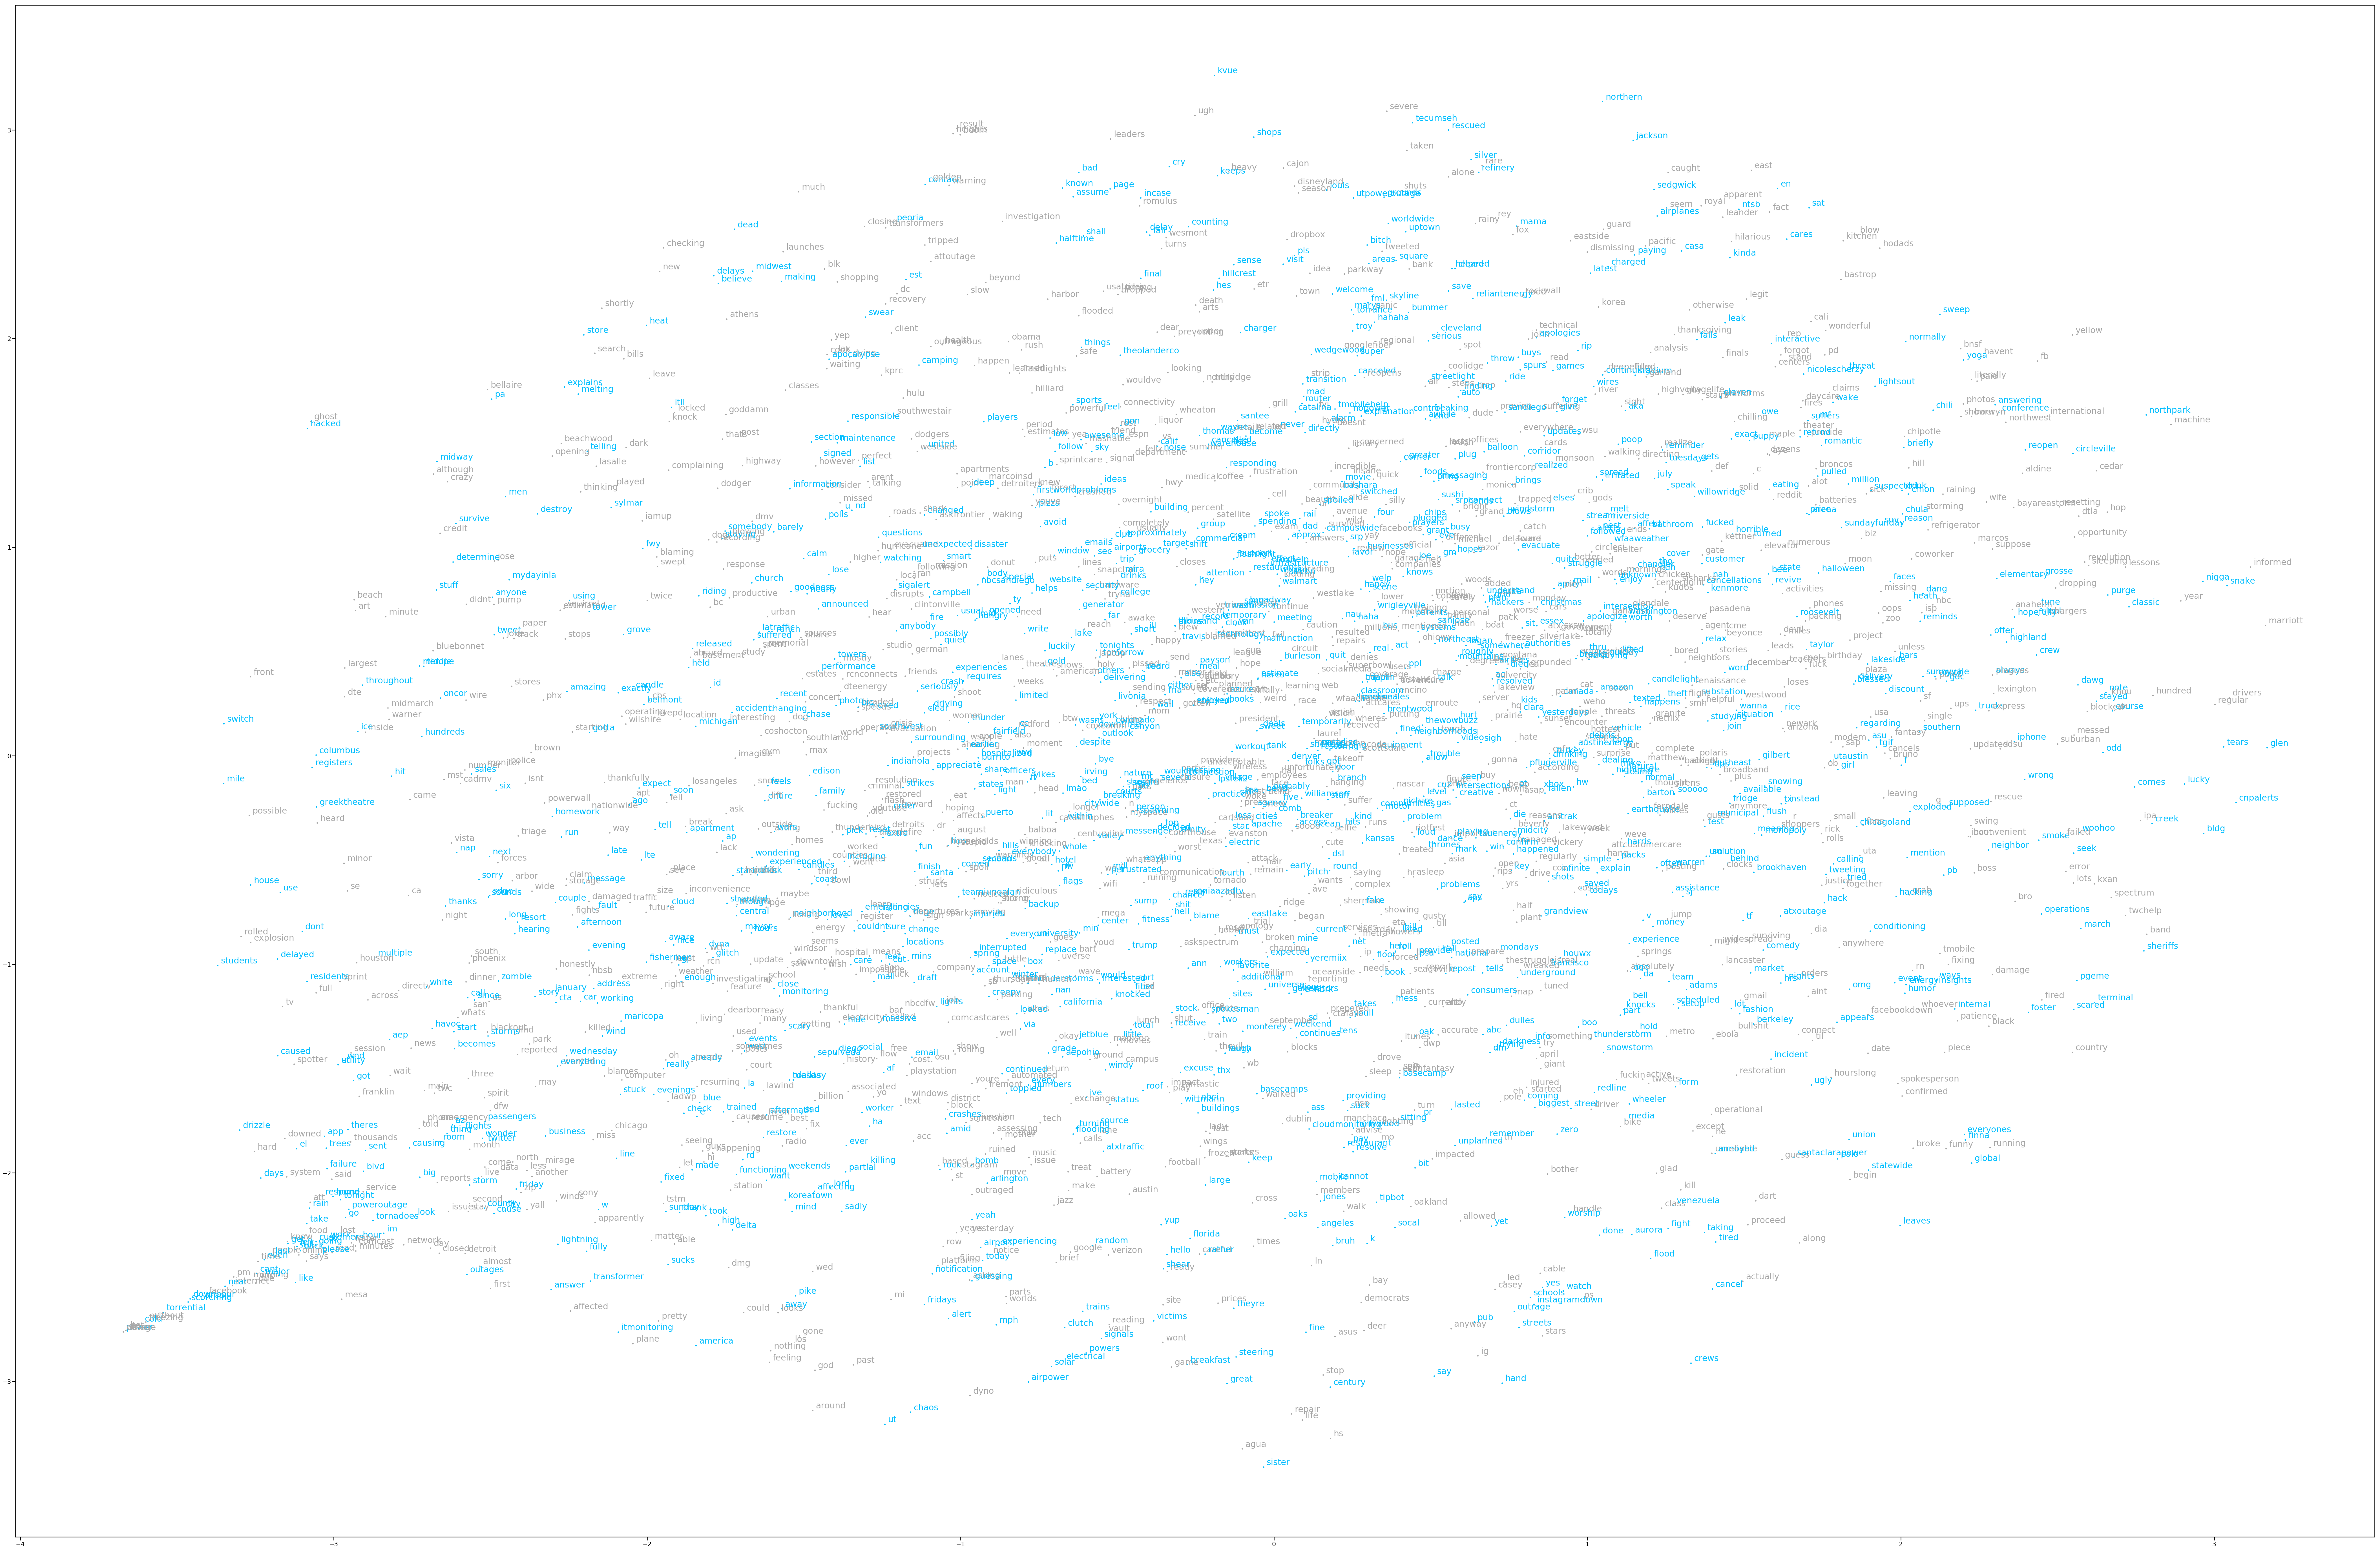

In [39]:
#plotting the t-SNE
plt.figure(figsize = (150,100))
colors = {'power_out':'deepskyblue', 'not_out':'darkgrey'}
for i,word in enumerate(points['word']):
    x = points['x'][i]
    y = points['y'][i]
    color = points['power_out_label'].apply(lambda x: colors[x])[i]
    plt.scatter(x, y, color=color, s = 10)
    plt.text(x+0.01, y+0.01, word,color = color, fontsize=30)
plt.show()

## Exporting Visual

This code will create and export an html file that will allow you to interact with the visual plot. The dots in blue represent the power being out, while gray dots are associated with it not being a legitimate power outage. The size of the dot also shows us how high it’s cosine similarity score is. Larger dots have larger scores, meaning a stronger relationship to either the positive or negative word list.

In [40]:
#creating and exporting an html file of the t-SNE plot

import numpy as np

from bokeh.plotting import figure, show, output_file,ColumnDataSource

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

source = ColumnDataSource(data = dict(
    x = points['x'],
    y = points['y'],
    label = points['power_out_label'],
    serious_cs = points['power_out_cs'],
    non_serious_cs = points['not_out_cs'],
    radii = ((points['power_out_cs']*points['power_out_label'].apply(lambda x: 1 if (x == 'power_out') else 0))+(points['not_out_cs']*points['power_out_label'].apply(lambda x: 0 if (x == 'power_out') else 1)))*0.25,
    color = points['power_out_label'].apply(lambda x: colors[x]),
    words = points['word']
))
TOOLTIPS =[
    ('word', '@words'),
    ('class','@label'),
    ('power out cos sim','@power_out_cs'),
    ('not out cos sim','@not_out_cs')
]
p = figure(title = 't-SNE Plot of Words in Tweets',
           tooltips=TOOLTIPS)

p.scatter('x', 'y', radius='radii', source = source,
          fill_color='color', line_color = None, fill_alpha=0.3)

output_file("./visualizations/tsne_scatter.html", title="tsne_scatter.py")

show(p)  # open a browser

## Evaluation

To evaluate our model’s performance, we had to manually confirm whether or not it was classified correctly. Ideally, we’d be able to go through all the tweets to confirm this but we ran out of time. We reviewed one thousand tweets and found six misclassifications. We’d need to review more to confirm whether this is what to expect in terms of number of misclassifications or an anomaly. From there we’d need to fine tune the model to lessen misclassifications. 

When we started this process, we believed that weather played a large role in power outages, and it does. However, we also discovered that the word “snakes” related high for flagging legitimate power outages. And that’s how we learned that snakes can climb into transformers and cause power outages. 

**Please continue to [3_Outage_Map_and_Next_Steps.ipynb](./3_Outage_Map_and_Next_Steps.ipynb) for the next step in the project: Outage Map**